# Transit model 

In this Jupyter notebook, we will see how to produce a model of the planetary transit in a light curve using the parameters from the literature. This is a preliminary passage to the fit of the model to the data.

Be sure to have installed the following packages: `batman`, `astroquery`, `ldtk`, `emcee`, `corner` 

Note that the `pip` name of the `batman` code is `batman-package` and that you have to explicitly install version 1.7 of `ldtk` (newer versions are not compatible with packages already installed in your environment).
Run this command from the AstroLab2 environment, from a terminal and NOT from a Jupyter Notebook
```bash
pip install batman-package astroquery ldtk==1.7 emcee corner  --user 
``` 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
import pickle
%matplotlib widget


After importing the usual packages, we load the TASTE and TESS light curves we have selected during the previous analysis.
Note: you need to analyse only the best TASTE and TESS light curves after selecting them through the criteria introduced during the previous lectures. There is no need to repeat this analysis for every light curve you obtained by applying different filtering algorithms or different reference stars. 

Note:  I'm importing the normalized TASTE lightcurve for plotting purposes only. In our analysis, we will need to use the differential photometry data *before* normalization, as the coefficient of the polynomial used for the normalization will also be optimised. 

In [2]:
taste_bjd_tdb = pickle.load(open('../TASTE/output_files/taste_bjdtdb.p','rb'))
differential_ap08_ref01_normalized = pickle.load(open('../TASTE/output_files/differential_ap08_ref01_normalized.p','rb'))
differential_ap08_ref01_normalized_error = pickle.load(open('../TASTE/output_files/differential_ap08_ref01_normalized_error.p','rb'))
differential_ap08_allref_normalized = pickle.load(open('../TASTE/output_files/differential_ap08_allref_normalized.p','rb'))
differential_ap08_allref_normalized_error = pickle.load(open('../TASTE/output_files/differential_ap08_allref_normalized_error.p','rb'))


differential_ap08_ref01 = pickle.load(open('../TASTE/output_files/differential_ap08_ref01.p','rb'))
differential_ap08_ref01_error = pickle.load(open('../TASTE/output_files/differential_ap08_ref01_error.p','rb'))
differential_ap08_allref = pickle.load(open('../TASTE/output_files/differential_ap08_allref.p','rb'))
differential_ap08_allref_error = pickle.load(open('../TASTE/output_files/differential_ap08_allref_error.p','rb'))

tess_bjd_tdb = pickle.load(open('../TESS/output_files/TESS_sector43_bjd_tdb.p','rb'))
sap_masked_huberspline = pickle.load(open('../TESS/output_files/TESS_sector43_sap_masked_huberspline.p','rb'))
sap_masked_huberspline_error = pickle.load(open('../TESS/output_files/TESS_sector43_sap_masked_huberspline_error.p','rb'))


`batman` (Bad-Ass Transit Model cAlculatioN, [Kreidberg 2015](https://ui.adsabs.harvard.edu/abs/2015PASP..127.1161K/abstract), [GitHub page](https://github.com/lkreidberg/batman
)] is a Python package for easy and fast calculation of transit light curves. 

Other packages are available, for example `pytransit` ([Parviainen 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.450.3233P/abstract), [GitHub page](https://github.com/hpparvi/PyTransit/)) and `ellc` ([Maxted 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...591A.111M/abstract), [GitHub page](https://github.com/pmaxted/ellc)), all providing well consistent and reliable results.


After reading the paper, we test the correctness of our installation by running one of the examples provided in the [documentation](https://lkreidberg.github.io/batman/docs/html/index.html
).

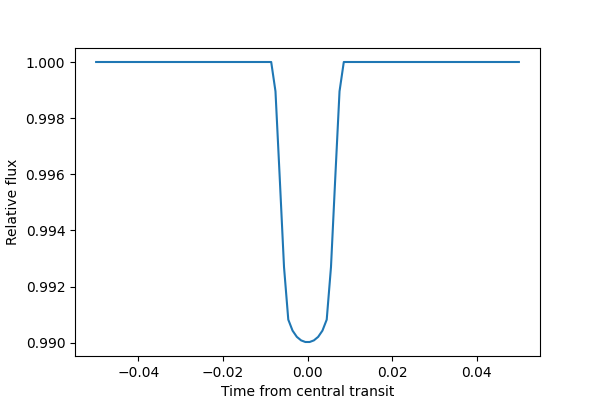

In [16]:
import batman

params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.                      #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

t = np.linspace(-0.05, 0.05, 100)
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve
plt.figure(figsize=(6,4))
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()


Below, you can find the list of parameters we need to change according to the values provided in the [ExoFOP website](https://exofop.ipac.caltech.edu/tess/) for our target. For better results, please use the values reported in *Planet Parameters: TOIs (TESS Project)*. For each parameter, I reported the name used in the ExoFOP table between parenthesis.

- `params.t0` : time of inferior conjunction (`Epoch`)
- `params.per`: orbital period of the planet, in days (`Period`)
- `params.rp`: scaled planetary radius, i.e., planet radius in units of stellar radii (`Rad_p/Rad_s`)
- `params.a`: scaled semi-major axis, i.e., semi-major axis in units of stellar radii (`a/Rad_s`)
- `params.inc`: orbital inclination in degrees (`Inclination`)

For our planet we will assume a circular orbit, so eccentricity and argument of periastron (incorrectly called *longitude of periastron* in the documentation) can be set to $0$ and $90$ respectively (see [Eastman et al. 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125...83E/abstract) for the reason behind these values)

Limb darkening coefficients depend on the photospheric parameters of the star and the filter used for the observations, so for now we are going to use the values provided in the example, although incorrect: \
`params.u`:   limb darkening coefficients [u1, u2]

The value of the limb darkening at a specific distance from the centre of the star can be described by several laws as well (linear, quadratic, power-2...). The quadratic limb darkening law is the most popular choice, although other laws may be more accurate (e.g., see [Morello et al.2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154..111M/abstract)). \
`params.limb_dark = "quadratic"`

After updating the parameters, we can produce several plots to compare our preliminary model with our data. 

In [4]:
import astropy.units as u
import astropy.constants as const

# Earth radius to Stellar radius
Er_Sr =  1*const.R_earth.to(const.R_sun).value
print(Er_Sr)

# AU to Solar radius
AU_Sr = 1*const.au.to(const.R_sun).value
print(AU_Sr)





0.009167888457668534
215.03215567054764


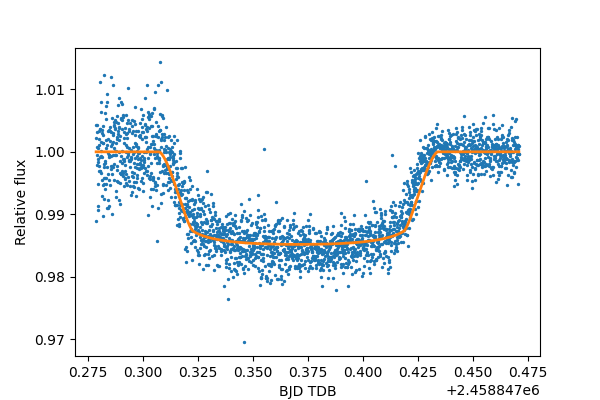

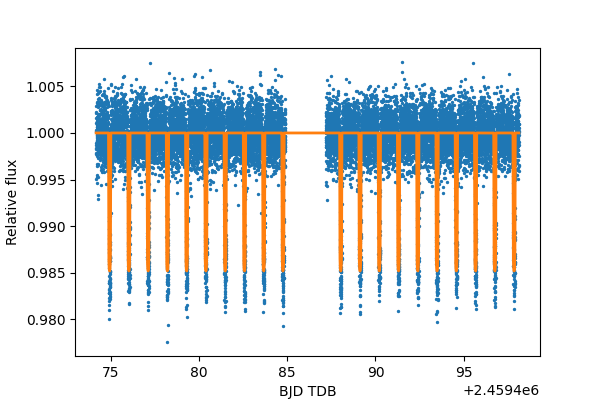

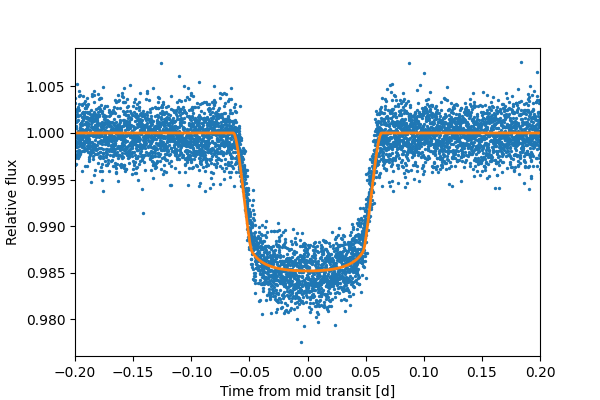

In [10]:

params = batman.TransitParams()
params.t0 = 2459550.243082                      #time of inferior conjunction 
params.per = 1.0914167                          #orbital period (days)
params.rp = 0.117                               #planet radius (in units of stellar radii)
params.a = 3.                                   #semi-major axis (in units of stellar radii)
params.inc = 83.52                              #orbital inclination (in degrees)
params.ecc = 0.                                 #eccentricity
params.w = 90.                                  #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                           #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"                  #limb darkening model

m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_flux = m_taste.light_curve(params)                #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_ap08_ref01_normalized, s=2)

plt.plot(taste_bjd_tdb, taste_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()


m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_flux =m_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, sap_masked_huberspline, s=2)
plt.plot(tess_bjd_tdb, tess_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, sap_masked_huberspline, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid transit [d]")
plt.ylabel("Relative flux")
plt.show()





# Limb darkening coefficients 

From the plots above, we can see that the models do not perfectly match our data. 
In the case of TASTE data, we have a mismatch in the timing of the transit, likely due to a small error in the planetary period propagating to the epoch of TASTE data (in my case, gathered more than one year after the TESS data). 
In both cases, the shape of the transit model does not closely follow our data during the central part of the transit, with the data having a more significant curvature than the model in the central part of the transit. This effect is due to improper limb darkening parameters.

Since the limb darkening parameters depend on the properties of the stellar atmosphere (parametrized through the effective temperature, surface gravity, and metallicity) and the transmissivity of the filter used to gather the data, their derivation is a challenging task. Fortunately for us, several researchers already went through the task of computing limb darkening as a function of those parameters (e.g., [Claret 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...618A..20C/abstract), [Claret et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...552A..16C/abstract)). In our analysis, we are going to use the Python Limb Darkening Toolkit (`ldtk`, [Parviainen & Aigrain 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.453.3821P/abstract), [GitHub page](https://github.com/hpparvi/ldtk)), a Python toolkit for calculating stellar limb darkening coefficients for arbitrary passbands using the stellar spectrum model library by [Husser et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...553A...6H/abstract). This tool provides access to the [ Spanish Virtual Observatory (SVO) Filter Profile Service (FPS). ](http://svo2.cab.inta-csic.es/theory/fps/) to retrieve the passband of the filters used to gather our data, thus further facilitating our job. The class uses `astroquery` to download the data, which naturally requires an internet connection.

After reading the paper and checking the documentation, we can adapt one of the many examples to check the transmissivity curves of our filters.

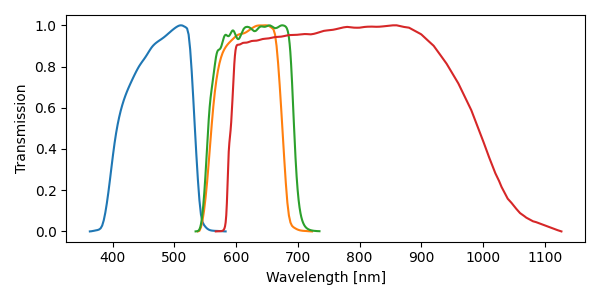

In [12]:

# Check which filter was used to gather the TASTE data, 
# different datasets may have been gathered with different filters: our case r-sloan (giusto anche per il nostro)

from ldtk import SVOFilter, LDPSetCreator
SVOFilter.shortcuts


sloan_g = SVOFilter('SLOAN/SDSS.g')
sloan_r = SVOFilter('SLOAN/SDSS.r')
sloan_rprime = SVOFilter('SLOAN/SDSS.rprime_filter')
tess_fr = SVOFilter('TESS')

fig, ax = plt.subplots(figsize=(6,3))
sloan_g.plot(ax=ax)             #blue
sloan_r.plot(ax=ax)             #yellow
sloan_rprime.plot(ax=ax)        #green
tess_fr.plot(ax=ax)             #red
fig.tight_layout()
plt.show()

We adapt another example to get the quadratic limb darkening coefficients for the two filters of interest, in my case`sloan_r` and `tess`, after retrieving the photospheric parameters (with the associated errors) of the target star, as discussed during one on the earlier lectures. 

In [20]:
filters = [
    sloan_r,
    tess_fr]
sc = LDPSetCreator(teff=(6154,106), logg=(4.02,0.08), z=(0.21,0.10), filters=filters)           # usare parametri stella nostri


ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z(100)

ps.set_uncertainty_multiplier(10)

qm,qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)

chains = np.array(ps._samples['qd'])


Need to download 94 files, approximately 31.40 MB


LDTk downloading uncached files:   0%|          | 0/94 [00:00<?, ?it/s]

Sloan r LD coefficients: u1 = 0.51 \pm 0.01    u2 = 0.14 \pm 0.03
TESS LD coefficients   : u1 = 0.41 \pm 0.01    u2 = 0.13 \pm 0.03


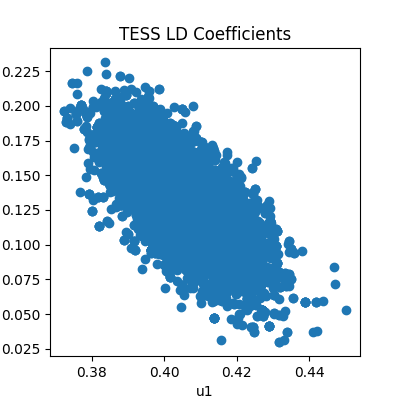

In [21]:
u1_sloan_r_chains = chains[0,:,0]
u2_sloan_r_chains = chains[0,:,1]

u1_tess_chains = chains[1,:,0]
u2_tess_chains = chains[1,:,1]

print('Sloan r LD coefficients: u1 = {0:4.2f} \pm {1:4.2f}    u2 = {2:4.2f} \pm {3:4.2f}'.format(
    np.mean(u1_sloan_r_chains), np.std(u1_sloan_r_chains),  
    np.mean(u2_sloan_r_chains), np.std(u2_sloan_r_chains),
))

print('TESS LD coefficients   : u1 = {0:4.2f} \pm {1:4.2f}    u2 = {2:4.2f} \pm {3:4.2f}'.format(
    np.mean(u1_tess_chains), np.std(u1_tess_chains),  
    np.mean(u2_tess_chains), np.std(u2_tess_chains),
))

plt.figure(figsize=(4,4))
plt.title('TESS LD Coefficients')
plt.xlabel('u1')
plt.ylabel('u2')
plt.scatter(u1_tess_chains, u2_tess_chains)
plt.show()

These are the limb darkening coefficients that I retrieved for my filters:

- Sloan r LD coefficients: $u1 = 0.51 \pm 0.02 \qquad   u2 = 0.14 \pm 0.05$
- TESS LD coefficients   : $u1 = 0.41 \pm 0.02 \qquad   u2 = 0.13 \pm 0.04$

The package provides error estimates for the coefficients. Still, those are computed by simply varying the stellar parameters according to their associated error *without considering the systematic errors due to the specific stellar atmosphere models used for the analysis*. In other words, employing different stellar models may produce a different set of coefficients, and this difference is not currently included in the estimate of the coefficients (e.g., see [Patel & Espinoza 2022](https://ui.adsabs.harvard.edu/abs/2022AJ....163..228P/abstract)). We will deal with this problem in two ways:
-  we will artificially enlarge the associated errors to the coefficient
- we will let the optimization tool free to explore different values for the coefficients 
We will see later on how to implement these two solutions.

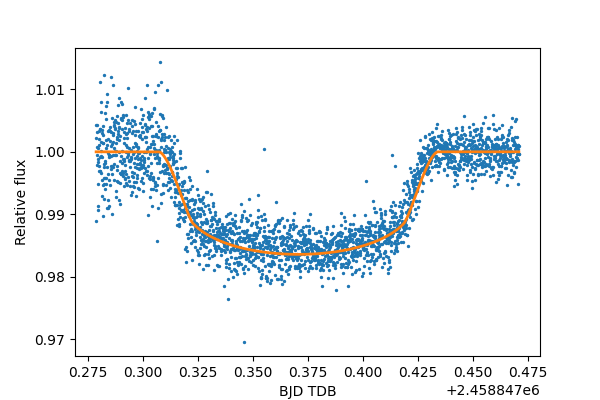

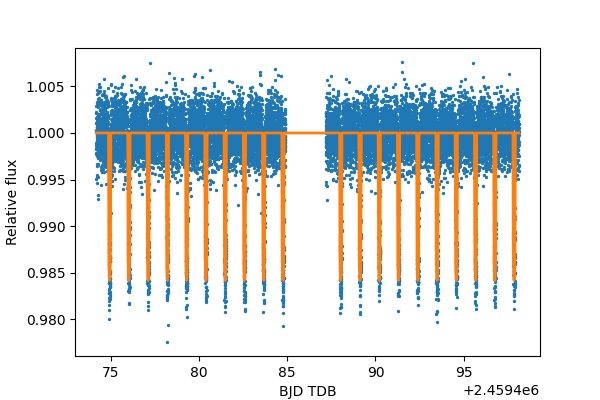

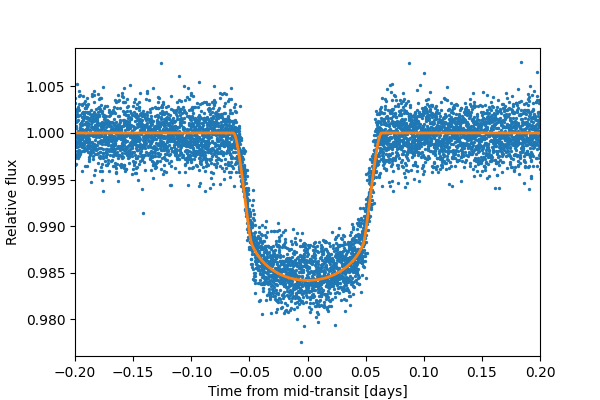

In [23]:

params = batman.TransitParams()
params.t0 = 2459550.243082                      #time of inferior conjunction
params.per = 1.0914167                      #orbital period (days)
params.rp = 0.117                      #planet radius (in units of stellar radii)
params.a = 3.                       #semi-major axis (in units of stellar radii)
params.inc = 83.52                      #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)


###TASTE LD
params.u = [0.51, 0.14]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_flux = m_taste.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_ap08_ref01_normalized, s=2)

plt.plot(taste_bjd_tdb, taste_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

###TESS LD
params.u = [0.41, 0.13]             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model


m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_flux =m_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, sap_masked_huberspline, s=2)
plt.plot(tess_bjd_tdb, tess_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, sap_masked_huberspline, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative flux")
plt.show()


There are still inconsistencies between the TASTE observations and the model regarding the transit timing, but now the shape of the transit model resembles the data much better than before.